In [1]:
import pandas as pd
import numpy as np
import sklearn as sk 
import dateutil
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from numpy import sqrt

In [2]:
df = pd.read_csv(r'C:\Users\Varshith\Desktop\homeworks\energydata\energy_train.csv')
df_val = pd.read_csv(r'C:\Users\Varshith\Desktop\homeworks\energydata\energy_val.csv')
df_test = pd.read_csv(r'C:\Users\Varshith\Desktop\homeworks\energydata\energy_test.csv')

In [3]:
df["hours"]=(df['date'].str.split(':').str[0].str.split(" ").str[1]).astype(str).astype(int)
df['hour*lights'] = df.hours * df.lights
df['hour_avg'] = list(map(dict(df.groupby('hours')["Appliances"].mean()).get, df.hours))
df_val["hours"]=(df_val['date'].str.split(':').str[0].str.split(" ").str[1]).astype(str).astype(int)
df_val['hour*lights'] = df_val.hours * df_val.lights
df_val['hour_avg'] = list(map(dict(df_val.groupby('hours')["Appliances"].mean()).get, df_val.hours))
df_test["hours"]=(df_test['date'].str.split(':').str[0].str.split(" ").str[1]).astype(str).astype(int)
df_test['hour*lights'] = df_test.hours * df_test.lights
df_test['hour_avg'] = list(map(dict(df_test.groupby('hours')["Appliances"].mean()).get, df_test.hours))

In [4]:
X_train=df.drop(['Appliances', 'date'], axis = 1).values
Y_train = df[['Appliances']].values
X_val=df_val.drop(['Appliances', 'date'], axis = 1).values
Y_val = df_val['Appliances'].values
X_test=df_test.drop(['Appliances', 'date'], axis = 1).values
Y_test = df_test['Appliances'].values

In [5]:
Y_train.shape

(9868, 1)

In [8]:
from sklearn.base import RegressorMixin
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

def compute_residual(y_true, y_pred):
    return  y_true - y_pred

class SGTB(RegressorMixin):
    def __init__(self, nIter=1, q=1, nu=0.1, md=3):
        self.nIter = nIter
        self.q = q
        self.nu = nu
        self.md = md
        self.y_mean = 0
        self.train_dict = {}
        self.trees = []

    def fit(self, x, y):
        self.y_mean = np.mean(y)
        y_pred = np.repeat(self.y_mean, len(y))
        r = compute_residual(y.reshape(len(y),), y_pred)
        self.train_dict[0] = np.sqrt(np.mean(r**2))
        for i in range(1, self.nIter+1):
            subsample_idx = np.random.choice(len(x), size=int(len(x)*self.q), replace=False)
            x_sub = x[subsample_idx] 
            r_sub = r[subsample_idx]
            tree = DecisionTreeRegressor(max_depth=self.md)
            tree.fit(x_sub, r_sub)
            self.trees.append(tree)
            y_pred = y_pred + self.nu * tree.predict(x)
            r = compute_residual(y.reshape(len(y),), y_pred)
            self.train_dict[i] = np.sqrt(np.mean(r**2))
        return self
    def get_params(self, deep=True):
        return {"nIter": self.nIter,
                "q": self.q,
                "nu": self.nu,
                "md": self.md}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def predict(self, x):
        y_pred = np.repeat((self.y_mean), len(x))
        for i in range(self.nIter):
            tree = self.trees[i]
            update = self.nu * tree.predict(x)
            y_pred = y_pred + update
        return y_pred

In [9]:
sgtb = SGTB(nIter=10, nu=0.5, q=1, md=3)
sgtb.fit(X_train, Y_train)

In [10]:
y_pred = sgtb.predict(X_val)

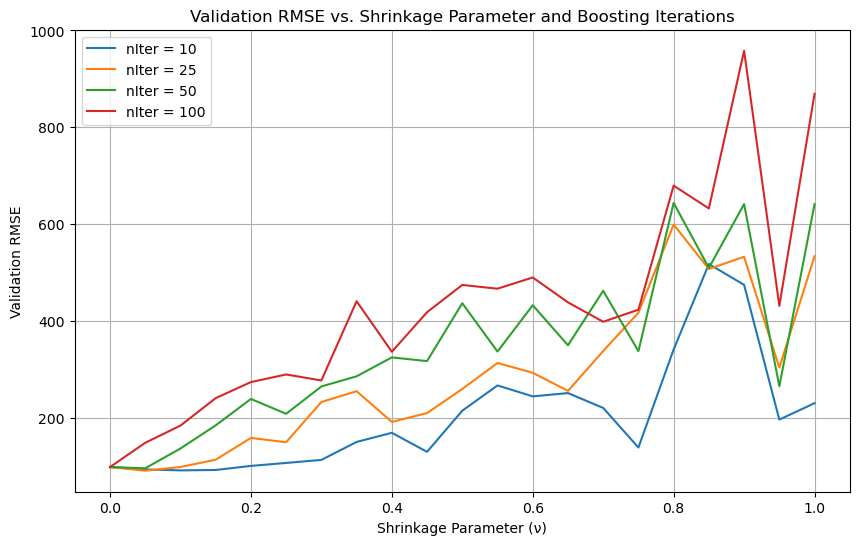

In [11]:

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

nu_values = np.linspace(0, 1, 21)
nIter_values = [10, 25, 50, 100]  

rmse_values = np.zeros((len(nu_values), len(nIter_values)))

for i, nu in enumerate(nu_values):
    for j, nIter in enumerate(nIter_values):
        sgtb = SGTB(nIter=nIter, nu=nu, q=1, md=3)
        sgtb.fit(X_train, Y_train)
        y_pred = sgtb.predict(X_val)
        rmse = np.sqrt(mean_squared_error(Y_val, y_pred))
        rmse_values[i][j] = rmse


plt.figure(figsize=(10, 6))
for j, nIter in enumerate(nIter_values):
    plt.plot(nu_values, rmse_values[:, j], label=f'nIter = {nIter}')
plt.xlabel('Shrinkage Parameter (ν)')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE vs. Shrinkage Parameter and Boosting Iterations')
plt.legend()
plt.grid(True)
plt.show()


In [12]:
min_rmse = np.min(rmse_values)
min_idx = np.unravel_index(np.argmin(rmse_values), rmse_values.shape)
best_nu_idx, best_nIter_idx = min_idx
best_nu = nu_values[best_nu_idx]
best_nIter = nIter_values[best_nIter_idx]
print(best_nu, best_nIter, min_rmse)

0.05 25 90.11223349662716


In [13]:
sgt = SGTB(nIter=best_nIter, nu = best_nu, q=1, md=3)
sgt.fit(X_train, Y_train)
y_pred = sgt.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))

In [14]:
rmse

92.7578887771433

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error

def tune_sgtb(x,y, nIter_values, nu_values, q_values, max_depth):
  

  # Create parameter grid
    param_grid = {'nIter': nIter_values,
                'nu': nu_values,
                'q': q_values}

    neg_mse = make_scorer(mean_squared_error, greater_is_better=False)
    gs = GridSearchCV(SGTB(), param_grid, cv=5, scoring=neg_mse)
    gs.fit(x, y)
    best_params = gs.best_params_
    # Extract best hyperparameter values
    best_nIter = best_params['nIter'] 
    best_nu = best_params['nu']
    best_q = best_params['q']

    # Return in dictionary
    return {'best-nIter': best_nIter, 
          'best-nu': best_nu,
          'best-q': best_q}

In [16]:
q_values = [0.6, 0.7, 0.8, 0.9, 1.0]
params = tune_sgtb(X_val, Y_val, nIter_values, nu_values, q_values, max_depth=3)
print(params)

{'best-nIter': 25, 'best-nu': 0.05, 'best-q': 0.8}


In [42]:
import time
start_time = time.time()

sgt = SGTB(nIter=params['best-nIter'], nu = params['best-nu'], q= params['best-q'], md=3)
sgt.fit(X_train, Y_train)
y_pred = sgt.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))

duration = time.time() - start_time
duration

1.9761314392089844

In [43]:
rmse

89.36113397926555

In [45]:
import time
start_time = time.time()

sgt = SGTB(nIter=best_nIter, nu = best_nu, q=1, md=3)
sgt.fit(X_train, Y_train)
y_pred = sgt.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, y_pred))

duration = time.time() - start_time
duration

2.5727031230926514

In [46]:
rmse

92.75788877714328